# Pyspatialml
## Example Classification

Here we are going to perform a simple classification of landsat data, using training points that were created from a previous year's classification. The data for this example is derived from the GRASS GIS North Carolina Example Dataset.

In [1]:
from osgeo import gdal
from pyspatialml import predict, extract
import geopandas
import rasterio.plot
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline
os.chdir(os.path.join(os.getcwd(), 'Pyspatialml', 'Examples'))

Raster data as single bands, and training points as a shapefile:

In [2]:
band1 = 'lsat7_2000_10.tif'
band2 = 'lsat7_2000_20.tif'
band3 = 'lsat7_2000_30.tif'
band4 = 'lsat7_2000_40.tif'
band5 = 'lsat7_2000_50.tif'
band7 = 'lsat7_2000_70.tif'
training_points = 'landclass96_roi.shp'

We are going to use a GDAL VRT (Virtual Tile Format) to 'stack' the bands without physically making a copy of the data:

In [3]:
predictors = [band1, band2, band3, band4, band5, band7]
vrt_file = 'landsat.vrt'
outds = gdal.BuildVRT(
    destName=vrt_file, srcDSOrSrcDSTab=predictors, separate=True,
    resolution='highest', resampleAlg='bilinear')
outds.FlushCache()

Read the training data as a geopandas dataframe:

In [4]:
# read vector data
training_gpd = geopandas.read_file(training_points)

Show training data and a single raster band:

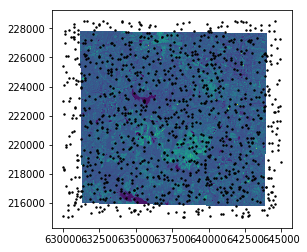

In [8]:
# plotting
src = rasterio.open(vrt_file)
srr_arr = src.read(4, masked=True)
plt.imshow(srr_arr, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.scatter(x=training_gpd.bounds.iloc[:, 0], y=training_gpd.bounds.iloc[:, 1],
            s=2, color='black')
plt.show()

Extracting training data from locations of geopandas array:

In [9]:
# extract using pyspatialml
X, y, xy = extract(dataset=src, response=training_gpd, field='id')

Get valid entries only to pass to the classifier

In [10]:
X = X[~X.mask.any(axis=1)]
y = y[~y.mask]

Training model:

In [11]:
# classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X, y)
scores = cross_validate(clf, X, y, cv=3, scoring=['accuracy'])
scores['test_accuracy'].mean()

0.6584391382263722

Prediction on raster vrt file:

In [12]:
result = predict(estimator=clf, dataset=src, file_path='classification.tif')

  0%|          | 0/111 [00:00<?, ?it/s]

  1%|          | 1/111 [00:00<00:27,  3.97it/s]

  2%|▏         | 2/111 [00:00<00:29,  3.70it/s]

  3%|▎         | 3/111 [00:00<00:25,  4.26it/s]

  4%|▎         | 4/111 [00:00<00:23,  4.55it/s]

  5%|▍         | 5/111 [00:01<00:23,  4.59it/s]

  5%|▌         | 6/111 [00:01<00:25,  4.10it/s]

  6%|▋         | 7/111 [00:01<00:25,  4.11it/s]

  7%|▋         | 8/111 [00:01<00:23,  4.30it/s]

  8%|▊         | 9/111 [00:02<00:23,  4.40it/s]

  9%|▉         | 10/111 [00:02<00:22,  4.46it/s]

 10%|▉         | 11/111 [00:02<00:22,  4.52it/s]

 11%|█         | 12/111 [00:02<00:22,  4.44it/s]

 12%|█▏        | 13/111 [00:02<00:22,  4.38it/s]

 13%|█▎        | 14/111 [00:03<00:22,  4.27it/s]

 14%|█▎        | 15/111 [00:03<00:22,  4.28it/s]

 14%|█▍        | 16/111 [00:03<00:22,  4.26it/s]

 15%|█▌        | 17/111 [00:03<00:21,  4.28it/s]

 16%|█▌        | 18/111 [00:04<00:21,  4.28it/s]

 17%|█▋        | 19/111 [00:04<00:21,  4.26it/s]

 18%|█▊        | 20/111 [00:04<00:21,  4.26it/s]

 19%|█▉        | 21/111 [00:04<00:21,  4.23it/s]

 20%|█▉        | 22/111 [00:05<00:20,  4.24it/s]

 21%|██        | 23/111 [00:05<00:20,  4.22it/s]

 22%|██▏       | 24/111 [00:05<00:20,  4.24it/s]

 23%|██▎       | 25/111 [00:05<00:22,  3.89it/s]

 23%|██▎       | 26/111 [00:06<00:22,  3.72it/s]

 24%|██▍       | 27/111 [00:06<00:22,  3.67it/s]

 25%|██▌       | 28/111 [00:06<00:21,  3.81it/s]

 26%|██▌       | 29/111 [00:06<00:20,  3.94it/s]

 27%|██▋       | 30/111 [00:07<00:20,  4.02it/s]

 28%|██▊       | 31/111 [00:07<00:20,  3.86it/s]

 29%|██▉       | 32/111 [00:07<00:20,  3.79it/s]

 30%|██▉       | 33/111 [00:07<00:20,  3.88it/s]

 31%|███       | 34/111 [00:08<00:19,  3.94it/s]

 32%|███▏      | 35/111 [00:08<00:19,  3.95it/s]

 32%|███▏      | 36/111 [00:08<00:19,  3.87it/s]

 33%|███▎      | 37/111 [00:08<00:18,  3.99it/s]

 34%|███▍      | 38/111 [00:09<00:18,  4.04it/s]

 35%|███▌      | 39/111 [00:09<00:17,  4.09it/s]

 36%|███▌      | 40/111 [00:09<00:17,  4.07it/s]

 37%|███▋      | 41/111 [00:09<00:17,  4.11it/s]

 38%|███▊      | 42/111 [00:10<00:16,  4.16it/s]

 39%|███▊      | 43/111 [00:10<00:16,  4.21it/s]

 40%|███▉      | 44/111 [00:10<00:15,  4.22it/s]

 41%|████      | 45/111 [00:10<00:15,  4.16it/s]

 41%|████▏     | 46/111 [00:11<00:15,  4.18it/s]

 42%|████▏     | 47/111 [00:11<00:15,  4.22it/s]

 43%|████▎     | 48/111 [00:11<00:14,  4.22it/s]

 44%|████▍     | 49/111 [00:11<00:14,  4.18it/s]

 45%|████▌     | 50/111 [00:12<00:14,  4.19it/s]

 46%|████▌     | 51/111 [00:12<00:15,  3.95it/s]

 47%|████▋     | 52/111 [00:12<00:14,  3.95it/s]

 48%|████▊     | 53/111 [00:12<00:14,  3.95it/s]

 49%|████▊     | 54/111 [00:13<00:14,  4.04it/s]

 50%|████▉     | 55/111 [00:13<00:13,  4.01it/s]

 50%|█████     | 56/111 [00:13<00:14,  3.91it/s]

 51%|█████▏    | 57/111 [00:13<00:14,  3.64it/s]

 52%|█████▏    | 58/111 [00:14<00:13,  3.80it/s]

 53%|█████▎    | 59/111 [00:14<00:13,  3.90it/s]

 54%|█████▍    | 60/111 [00:14<00:12,  3.93it/s]

 55%|█████▍    | 61/111 [00:14<00:12,  3.94it/s]

 56%|█████▌    | 62/111 [00:15<00:12,  3.91it/s]

 57%|█████▋    | 63/111 [00:15<00:12,  3.96it/s]

 58%|█████▊    | 64/111 [00:15<00:11,  4.01it/s]

 59%|█████▊    | 65/111 [00:15<00:11,  3.94it/s]

 59%|█████▉    | 66/111 [00:16<00:11,  3.89it/s]

 60%|██████    | 67/111 [00:16<00:11,  3.83it/s]

 61%|██████▏   | 68/111 [00:16<00:11,  3.78it/s]

 62%|██████▏   | 69/111 [00:17<00:11,  3.66it/s]

 63%|██████▎   | 70/111 [00:17<00:10,  3.77it/s]

 64%|██████▍   | 71/111 [00:17<00:10,  3.93it/s]

 65%|██████▍   | 72/111 [00:17<00:09,  4.02it/s]

 66%|██████▌   | 73/111 [00:17<00:09,  4.09it/s]

 67%|██████▋   | 74/111 [00:18<00:09,  4.00it/s]

 68%|██████▊   | 75/111 [00:18<00:08,  4.08it/s]

 68%|██████▊   | 76/111 [00:18<00:08,  4.06it/s]

 69%|██████▉   | 77/111 [00:18<00:08,  4.16it/s]

 70%|███████   | 78/111 [00:19<00:07,  4.19it/s]

 71%|███████   | 79/111 [00:19<00:07,  4.22it/s]

 72%|███████▏  | 80/111 [00:19<00:07,  4.23it/s]

 73%|███████▎  | 81/111 [00:19<00:07,  4.21it/s]

 74%|███████▍  | 82/111 [00:20<00:06,  4.20it/s]

 75%|███████▍  | 83/111 [00:20<00:06,  4.20it/s]

 76%|███████▌  | 84/111 [00:20<00:06,  4.25it/s]

 77%|███████▋  | 85/111 [00:20<00:06,  4.22it/s]

 77%|███████▋  | 86/111 [00:21<00:05,  4.20it/s]

 78%|███████▊  | 87/111 [00:21<00:05,  4.20it/s]

 79%|███████▉  | 88/111 [00:21<00:05,  4.25it/s]

 80%|████████  | 89/111 [00:21<00:05,  4.22it/s]

 81%|████████  | 90/111 [00:22<00:04,  4.25it/s]

 82%|████████▏ | 91/111 [00:22<00:04,  4.25it/s]

 83%|████████▎ | 92/111 [00:22<00:04,  4.25it/s]

 84%|████████▍ | 93/111 [00:22<00:04,  4.26it/s]

 85%|████████▍ | 94/111 [00:22<00:04,  4.23it/s]

 86%|████████▌ | 95/111 [00:23<00:03,  4.21it/s]

 86%|████████▋ | 96/111 [00:23<00:03,  4.19it/s]

 87%|████████▋ | 97/111 [00:23<00:03,  4.18it/s]

 88%|████████▊ | 98/111 [00:23<00:03,  4.20it/s]

 89%|████████▉ | 99/111 [00:24<00:02,  4.23it/s]

 90%|█████████ | 100/111 [00:24<00:02,  4.24it/s]

 91%|█████████ | 101/111 [00:24<00:02,  4.32it/s]

 92%|█████████▏| 102/111 [00:24<00:02,  4.34it/s]

 93%|█████████▎| 103/111 [00:25<00:01,  4.46it/s]

 94%|█████████▎| 104/111 [00:25<00:01,  4.54it/s]

 95%|█████████▍| 105/111 [00:25<00:01,  4.64it/s]

 95%|█████████▌| 106/111 [00:25<00:01,  4.71it/s]

 96%|█████████▋| 107/111 [00:25<00:00,  4.76it/s]

 97%|█████████▋| 108/111 [00:26<00:00,  5.06it/s]

 98%|█████████▊| 109/111 [00:26<00:00,  5.42it/s]

 99%|█████████▉| 110/111 [00:26<00:00,  5.42it/s]

100%|██████████| 111/111 [00:26<00:00,  6.01it/s]

Plotting of results:

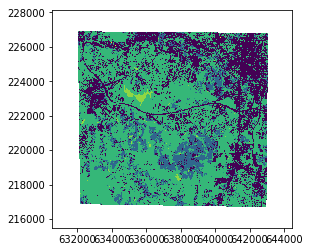

In [13]:
rasterio.plot.show(result)
result.close()